# MissForest Model

In [198]:
library("mice")
library("VIM")
library("crunch")
library("missForest")

First we read the data, where "test_missing1.csv.gz" and "test_complete1.csv.gz" are generated in the "[03 - Test Data.ipynb](https://github.com/Galeforse/DST-Assessment-02/blob/main/Report/03%20-%20Test%20Data.ipynb)" notebook, the former contains missing values, and the latter has corresponding real values. We run the model that predicts missing values on the first dataset.

In [199]:
setwd("C:\\Users\\xiao\\Documents\\GitHub\\DST-Assessment-02\\Data")
conndata<-read.table("5_percent_data.csv.gz", sep=",", header=TRUE, na.strings=c("","NA"))
data.missing<-read.table("test_missing1.csv.gz", sep=",", header=TRUE, na.strings=c("","NA"))
data.complete<-read.table("test_complete1.csv.gz", sep=",", header=TRUE, na.strings=c("","NA"))

## Observing missing data

In [219]:
for(i in c(3,5,8,9,10,12,14:17)) conndata[,i]=as.numeric(conndata[,i])
for(i in c(2,4,6,11,13)) conndata[,i]=as.factor(conndata[,i])
head(conndata)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,NA,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,NA,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40


,ts,orig_ip,orig_port,resp_ip,resp_port,proto,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,duration,orig_bytes,resp_bytes,service,
25309,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
169671,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
8195,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,3
931542,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,4
,0,0,0,0,0,0,0,0,0,0,0,0,0,939737,939737,939737,1101213,3920424


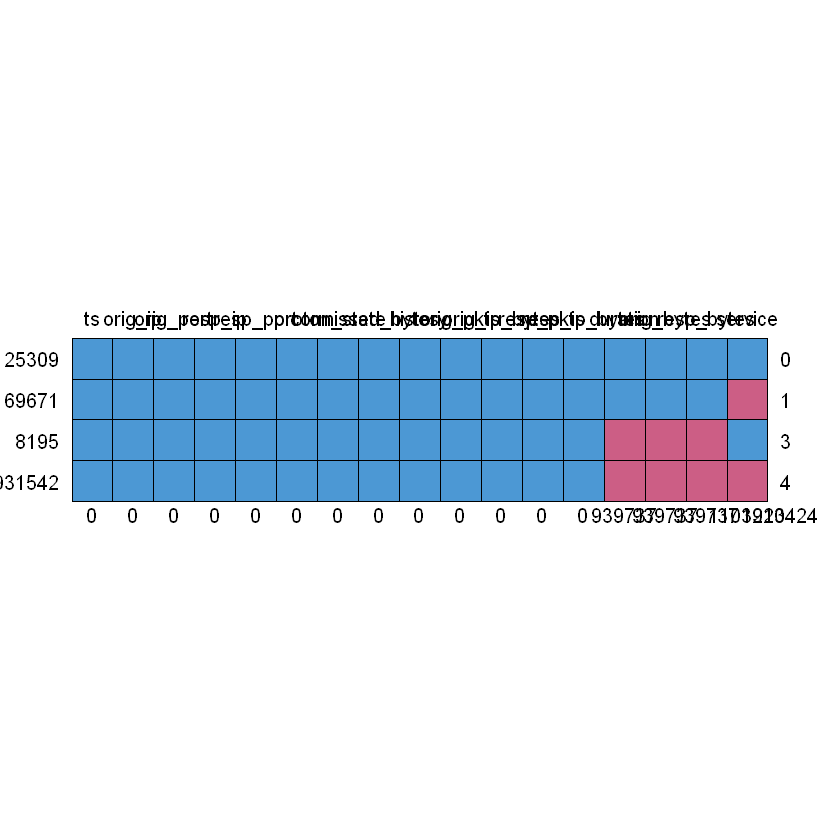

In [22]:
md.pattern(conndata)


 Variables sorted by number of missings: 
   Variable     Count
    service 0.9704737
   duration 0.8281686
 orig_bytes 0.8281686
 resp_bytes 0.8281686


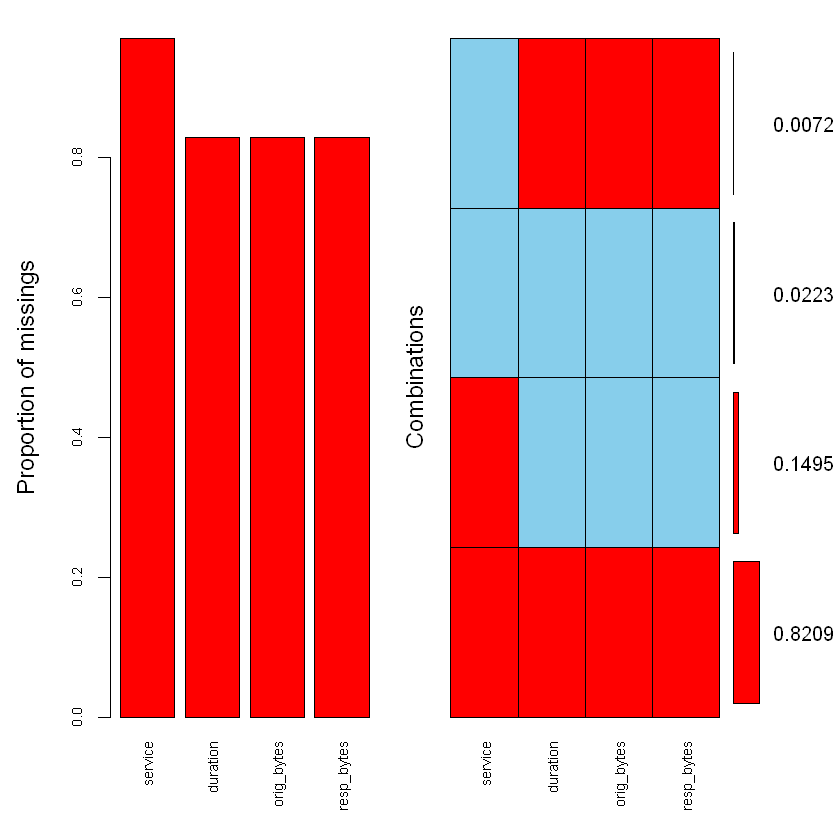

In [23]:
aggr(conndata[,which(names(conndata) %in% c("service","duration","orig_bytes","resp_bytes"))],
                  numbers=TRUE, sortVars=TRUE,cex.axis=.7,gap=3)

In the previous notebook, we have done a lot of exploratory analysis on this dataset, here is just for review.

The goal of our model is to predict the missing values of the three numerical variables "duration", "orig_bytes" and "resp_bytes".

And the model runs on "data.missing" dataset and compares it with the real values in "data.complete" dataset. Let's check them.

### data.complete

In [201]:
for(i in c(3,5,8,9,10,12,14:17)) data.complete[,i]=as.numeric(data.complete[,i])
for(i in c(2,4,6,11,13)) data.complete[,i]=as.factor(data.complete[,i])
head(data.complete)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331921224,192.168.202.102,4094,192.168.24.101,80,tcp,NA,0.01,7085,172,RSTO,0,ShADadfR,10,7497,9,544
3,1331903910,192.168.202.110,16066,192.168.27.152,12486,tcp,NA,0.01,0,0,REJ,0,Sr,1,48,1,40
4,1331988939,192.168.204.45,42997,192.168.23.1,28745,tcp,NA,0.01,0,0,REJ,0,Sr,1,60,1,40
5,1331918792,192.168.202.110,38566,192.168.229.252,32754,tcp,NA,0.20,0,0,REJ,0,Sr,1,48,1,40
6,1331901863,192.168.202.79,63805,192.168.229.252,45078,tcp,NA,0.06,0,0,REJ,0,Sr,1,44,1,40



 Variables sorted by number of missings: 
   Variable     Count
    service 0.8701969
   duration 0.0000000
 orig_bytes 0.0000000
 resp_bytes 0.0000000


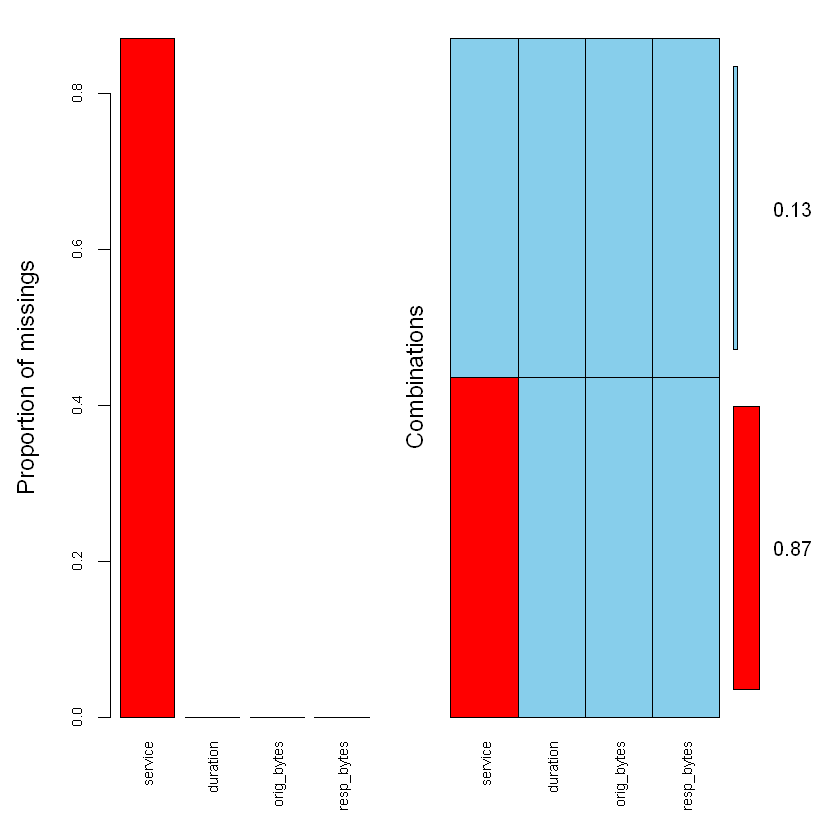

In [25]:
aggr(data.complete[,which(names(data.complete) %in% c("service","duration","orig_bytes","resp_bytes"))],
                  numbers=TRUE, sortVars=TRUE,cex.axis=.7,gap=3)

### data.missing

In [202]:
for(i in c(3,5,8,9,10,12,14:17)) data.missing[,i]=as.numeric(data.missing[,i])
for(i in c(2,4,6,11,13)) data.missing[,i]=as.factor(data.missing[,i])
head(data.missing)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,NA,NA,NA,RSTO,0,ShADadfR,8,813,9,8505
2,1331921224,192.168.202.102,4094,192.168.24.101,80,tcp,NA,0.01,7085,172,RSTO,0,ShADadfR,10,7497,9,544
3,1331903910,192.168.202.110,16066,192.168.27.152,12486,tcp,NA,NA,NA,NA,REJ,0,Sr,1,48,1,40
4,1331988939,192.168.204.45,42997,192.168.23.1,28745,tcp,NA,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331918792,192.168.202.110,38566,192.168.229.252,32754,tcp,NA,NA,NA,NA,REJ,0,Sr,1,48,1,40
6,1331901863,192.168.202.79,63805,192.168.229.252,45078,tcp,NA,NA,NA,NA,REJ,0,Sr,1,44,1,40



 Variables sorted by number of missings: 
   Variable     Count
    service 0.8701969
   duration 0.8281670
 orig_bytes 0.8281670
 resp_bytes 0.8281670


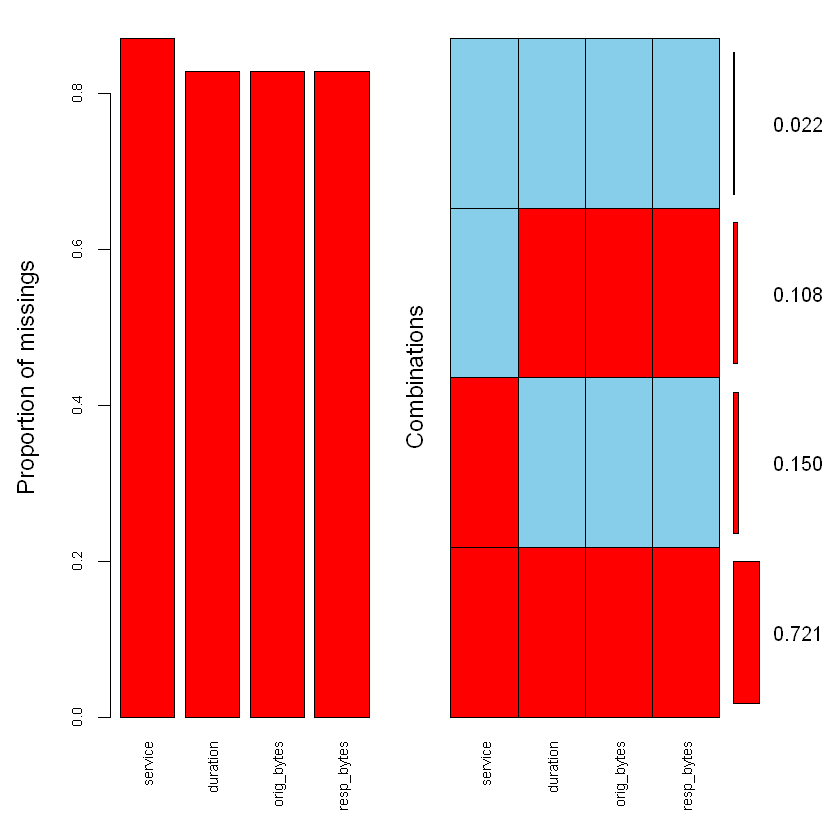

In [11]:
aggr(data.missing[,which(names(data.missing) %in% c("service","duration","orig_bytes","resp_bytes"))],
                  numbers=TRUE, sortVars=TRUE,cex.axis=.7,gap=3)

The following figure shows the distribution of missing values with monotonic changes in "ts". From it, we can't see obvious factors that affect data missing.

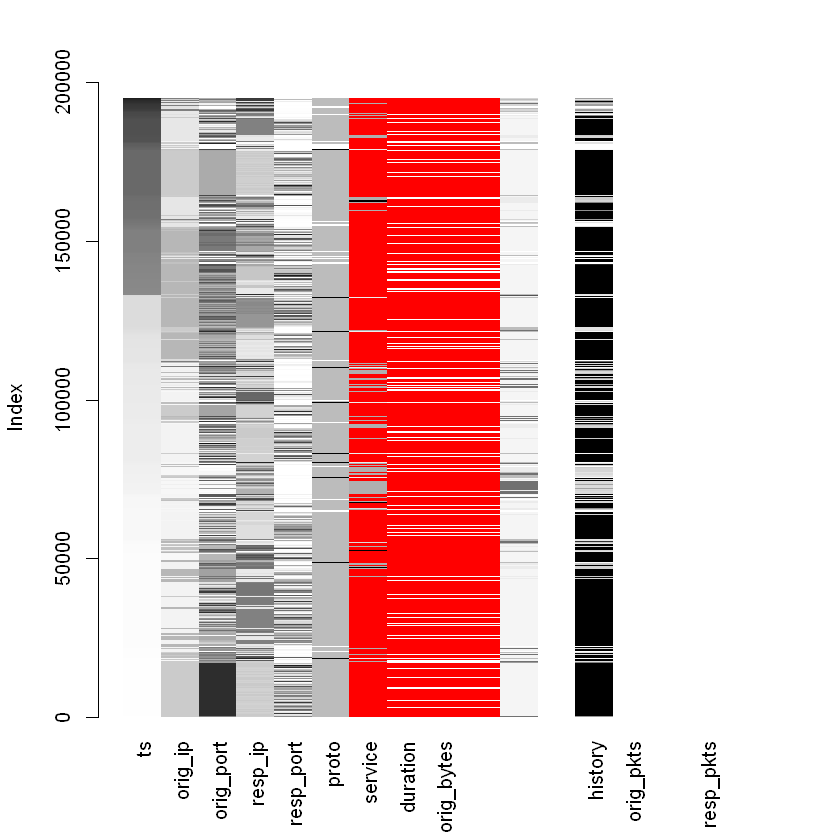

In [26]:
matrixplot(data.missing,sortby = "ts")

## Imputing the three continuous variables

Here we do not consider "service" because its missing rate is as high as 97%, which is an abnormal phenomenon. And it is a discrete variable. We don't know if there is a new classification, and the prediction method is different from the other three variables.

In [203]:
data.complete1<-data.complete[,-which(names(data.complete) %in% c("service"))]
data.missing1<-data.missing[,-which(names(data.missing) %in% c("service"))]
head(data.missing1)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,NA,NA,NA,RSTO,0,ShADadfR,8,813,9,8505
2,1331921224,192.168.202.102,4094,192.168.24.101,80,tcp,0.01,7085,172,RSTO,0,ShADadfR,10,7497,9,544
3,1331903910,192.168.202.110,16066,192.168.27.152,12486,tcp,NA,NA,NA,REJ,0,Sr,1,48,1,40
4,1331988939,192.168.204.45,42997,192.168.23.1,28745,tcp,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331918792,192.168.202.110,38566,192.168.229.252,32754,tcp,NA,NA,NA,REJ,0,Sr,1,48,1,40
6,1331901863,192.168.202.79,63805,192.168.229.252,45078,tcp,NA,NA,NA,REJ,0,Sr,1,44,1,40


According to the whorkshop4, one way to examine the imputation model's performance is by how much variation it explains.

We build a simple linear regression model, through this model, we can see the fit of "duration" and other variables. The closer the "R-squared" is to 1, the better the fit of the data, that is, the better the effect of imputation.

**Please note that this performance metric is not rigorous, it is just a reference and consideration here**

In [220]:
conndata[,"logduration"]=log(conndata[,"duration"])
lm1=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conndata)
summary(lm1) 


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conndata)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.1495  -0.9896  -0.4898   0.6171  11.2644 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       8.525e+03  1.039e+02  82.048  < 2e-16 ***
prototcp          2.487e+00  1.021e-01  24.364  < 2e-16 ***
protoudp          2.658e+00  1.061e-01  25.042  < 2e-16 ***
ts               -6.401e-06  7.801e-08 -82.052  < 2e-16 ***
orig_port        -7.968e-06  1.861e-07 -42.813  < 2e-16 ***
resp_port        -8.831e-07  1.725e-07  -5.119 3.07e-07 ***
conn_stateREJ    -5.507e+00  1.006e-01 -54.738  < 2e-16 ***
conn_stateRSTO   -5.249e+00  1.011e-01 -51.903  < 2e-16 ***
conn_stateRSTOS0  1.244e-01  4.489e-01   0.277    0.782    
conn_stateRSTR   -3.607e+00  1.035e-01 -34.838  < 2e-16 ***
conn_stateRSTRH  -4.267e-01  5.302e-01  -0.805    0.421

### Method 1: Deleting data with missing values

In [221]:
conn_delete<-conndata[complete.cases(conndata),] 

In [222]:
lm_delete=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_delete)
summary(lm_delete) 


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conn_delete)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.952  -1.086  -0.115   0.698   9.374 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     5.708e+03  4.195e+02  13.607  < 2e-16 ***
protoudp       -1.419e+00  1.304e-01 -10.884  < 2e-16 ***
ts             -4.283e-06  3.150e-07 -13.600  < 2e-16 ***
orig_port       1.774e-05  4.881e-07  36.355  < 2e-16 ***
resp_port      -5.716e-05  3.098e-06 -18.453  < 2e-16 ***
conn_stateRSTO -6.904e+00  1.604e+00  -4.303 1.69e-05 ***
conn_stateRSTR -3.002e+00  1.613e+00  -1.861 0.062774 .  
conn_stateS0   -1.262e+00  1.610e+00  -0.784 0.433096    
conn_stateS1   -4.123e+00  1.628e+00  -2.533 0.011315 *  
conn_stateS2    2.142e-02  1.702e+00   0.013 0.989957    
conn_stateS3   -3.014e+00  1.683e+00  -1.791 0.073322 .  
conn_stateSF   -6.135e+00 

Since most of the data have missing values, this method is too simple and crude, and is not suitable for use in practice

### Method 2: Mean imputation

In [129]:
data.mean<-data.missing
data.mean[is.na(data.mean[,"duration"]),
              "duration"]=
    mean(na.omit(data.mean[,"duration"]))

data.mean[is.na(data.mean[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(data.mean[,"orig_bytes"]))

data.mean[is.na(data.mean[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(data.mean[,"resp_bytes"]))

head(data.mean)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,1.419635,356075.8,1679.826,RSTO,0,ShADadfR,8,813,9,8505
2,1331921224,192.168.202.102,4094,192.168.24.101,80,tcp,NA,0.010000,7085.0,172.000,RSTO,0,ShADadfR,10,7497,9,544
3,1331903910,192.168.202.110,16066,192.168.27.152,12486,tcp,NA,1.419635,356075.8,1679.826,REJ,0,Sr,1,48,1,40
4,1331988939,192.168.204.45,42997,192.168.23.1,28745,tcp,NA,1.419635,356075.8,1679.826,REJ,0,Sr,1,60,1,40
5,1331918792,192.168.202.110,38566,192.168.229.252,32754,tcp,NA,1.419635,356075.8,1679.826,REJ,0,Sr,1,48,1,40
6,1331901863,192.168.202.79,63805,192.168.229.252,45078,tcp,NA,1.419635,356075.8,1679.826,REJ,0,Sr,1,44,1,40


In [16]:
lm_mean=lm(logduration~proto+ts+orig_port+resp_port+conn_state+orig_pkts+orig_ip_bytes +resp_pkts+resp_ip_bytes,data=conn_mean)
summary(lm_mean)


Call:
lm(formula = logduration ~ proto + ts + orig_port + resp_port + 
    conn_state + orig_pkts + orig_ip_bytes + resp_pkts + resp_ip_bytes, 
    data = conn_mean)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.0928  -0.0824   0.0241   0.1229  12.8767 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1.593e+03  4.716e+01  33.770  < 2e-16 ***
prototcp         -2.143e+00  2.419e-02 -88.584  < 2e-16 ***
protoudp         -1.000e+00  2.872e-02 -34.814  < 2e-16 ***
ts               -1.196e-06  3.541e-08 -33.788  < 2e-16 ***
orig_port        -1.444e-06  1.004e-07 -14.386  < 2e-16 ***
resp_port        -2.342e-06  7.291e-08 -32.123  < 2e-16 ***
conn_stateREJ    -1.587e-01  1.741e-02  -9.119  < 2e-16 ***
conn_stateRSTO   -2.316e-01  2.009e-02 -11.527  < 2e-16 ***
conn_stateRSTOS0  6.724e-03  6.964e-01   0.010    0.992    
conn_stateRSTR    9.268e-01  3.164e-02  29.288  < 2e-16 ***
conn_stateRSTRH  -1.083e-02  2.468e-01  -0.044    0.96

R-squared decreases, indicating that the effect of the mean imputation is not good. This is easy to understand, because the method of setting the value of hundreds of thousands of data as the overall mean is too crude.

For more research on mean imputation, please see "[05 - Further DA and Mean Impute.ipynb](https://github.com/Galeforse/DST-Assessment-02/blob/main/Report/05%20-%20Further%20DA%20and%20Mean%20Impute.ipynb)"notebook.

### Method 3: MissForest imputation

The package 'missForest' is used to impute missing values particularly in the case of mixed-type data. It uses a random forest trained on the observed values of a data matrix to predict the missing values. It can be used to impute continuous and/or categorical data including complex interactions and non-linear relations. It yields an out-of-bag (OOB) imputation error estimate without the need of a testset or elaborate cross-validation.

We first make an initial guess for the missing value, for instance, replace it with the mean/median replacement, and then sort the variable from small to large according to the missing rate of the variable, first use random forest regression for the variable with the small missing rate to replace the missing value of the variable , And then iterate until the latest replacement result and the last replacement result no longer change (or the change is small).

### Building the model

There are a lot of missing values in "service", the three discrete variables of "orig_ip", "resp_ip" and "history" have many categories, and we think that they have little effect on the missing variables, so we can remove them. (they can also be converted into numerical variables by one-hot code, but in order not to make the calculation process of the model too complicated, this is the work afterwards.)

In [139]:
data.missing2<-data.missing[,-which(names(data.missing) %in% c("service","orig_ip","resp_ip","history"))]
data.complete2<-data.complete[,-which(names(data.complete) %in% c("service","orig_ip","resp_ip","history"))]

In the function"missForest":

"**xtrue**" is the data with real values to calculate the built-in performance metrics of the function;

"**maxiter**" is the maximum number of iterations to be performed given the stopping criterion is not met beforehand, in order to avoid the program running time is too long, we set it to 10, that is, iterate at most ten times;

"**verbose=true**" outputs iteration process, including estimated error, difference, and time.

In [146]:
set.seed(10)
forest1<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 10)

  missForest iteration 1 in progress...done!
    error(s): 0.7928336 0 
    estimated error(s): 0.01940887 0 
    difference(s): 6.352048e-05 0 
    time: 15.06 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.7459329 0 
    estimated error(s): 0.01893483 0 
    difference(s): 6.386609e-05 0 
    time: 14.91 seconds



In [147]:
output.forest1<-forest1$ximp
head(output.forest1)
forest1$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,14.27558,3106.15769,8028.114,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000,7085.00000,172.000,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,19.11555,91.80019,17.500,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,19.04756,90.60019,1.600,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,19.11132,90.60019,17.500,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,19.05420,91.80019,17.500,REJ,0,1,44,1,40


NRMSE        PFC 
0.01940887 0.00000000

We can see that after two iterations, all missing data is imputed.

At the same time, the function"**$OOBerror**" outputs two performance metrics:

**NRMSE** represents "normalized root mean squared error computed"， which is a performance metric for continuous variable;

**PFC** represents "proportion of falsely classified", which is a performance metric for discrete variable, since we are not predicting discrete variables, it is 0.

### Researching parameters

The algorithm involving random forest is a black box to some extent, but we have a basic understanding of its principles and steps. Here we adjust the two most important parameters of the model to apply to the real  data:

"**ntree**" is the number of trees to grow in each forest, the default value is 100;

"**mtry**" is also an important parameter, which means the number of variables randomly sampled at each split. This argument is directly supplied to the 'randomForest' function. Note that the default value is sqrt(p) for both categorical and continuous variables where p is the number of variables in data.

### Establishing performance metrics

We choose the built-in "**NRMSE**" as a metric. 

In addition, we calculate the **correlation coefficient** of three variables. For example, we calculate the correlation coefficient of the "duration" column in "data_missing1" (after imputation) and the "duration" column in "data_complete1", the closer this value is to 1, the more successful the imputation is.

#### For "ntree"

We take the values 10, 30, 50, 70, and 5, and then run the iterative algorithm respectively to get the data frame of the imputation.

##### ntree = 30

In [152]:
forest2<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 30)

  missForest iteration 1 in progress...done!
    error(s): 1.233213 0 
    estimated error(s): 0.01843294 0 
    difference(s): 0.0005290394 0 
    time: 43.05 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.8774877 0 
    estimated error(s): 0.01805376 0 
    difference(s): 0.0004304837 0 
    time: 42.9 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.8313412 0 
    estimated error(s): 0.01763182 0 
    difference(s): 8.830291e-05 0 
    time: 48.27 seconds

  missForest iteration 4 in progress...done!
    error(s): 0.8803801 0 
    estimated error(s): 0.01756695 0 
    difference(s): 6.75408e-05 0 
    time: 45.88 seconds

  missForest iteration 5 in progress...done!
    error(s): 0.7488196 0 
    estimated error(s): 0.01716752 0 
    difference(s): 0.0001154925 0 
    time: 47.24 seconds



In [154]:
output.forest2<-forest2$ximp
head(output.forest2)
forest2$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,0.02846794,4.766848e+02,8.134712e+03,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000000,7.085000e+03,1.720000e+02,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,0.71132813,6.201778e-05,2.839698e-05,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,0.02165369,6.201768e-05,2.839698e-05,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,0.16481409,6.201768e-05,2.839698e-05,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,0.19584980,6.201778e-05,2.839698e-05,REJ,0,1,44,1,40


NRMSE        PFC 
0.01756695 0.00000000

##### ntree = 50

In [155]:
forest3<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 50)

  missForest iteration 1 in progress...done!
    error(s): 1.134209 0 
    estimated error(s): 0.01709791 0 
    difference(s): 0.0003774341 0 
    time: 76.12 seconds

  missForest iteration 2 in progress...done!
    error(s): 1.45594 0 
    estimated error(s): 0.0161226 0 
    difference(s): 0.0001907382 0 
    time: 72.89 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.755095 0 
    estimated error(s): 0.01793464 0 
    difference(s): 0.0007431185 0 
    time: 68.4 seconds



In [161]:
output.forest3<-forest3$ximp
head(output.forest3)
forest3$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,116.330727,2.571107e+07,9002.0559,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.010000,7.085000e+03,172.0000,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,9.903606,1.383312e+03,107.5925,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,7.963623,2.065337e+02,56.9563,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,4.797414,1.452743e+02,24.8763,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,147.316195,1.065925e+08,345.7650,REJ,0,1,44,1,40


NRMSE       PFC 
0.0161226 0.0000000

##### ntree = 70

In [162]:
forest4<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 70)

  missForest iteration 1 in progress...done!
    error(s): 1.037637 0 
    estimated error(s): 0.01647088 0 
    difference(s): 0.0003575509 0 
    time: 111.19 seconds

  missForest iteration 2 in progress...done!
    error(s): 1.564563 0 
    estimated error(s): 0.01683789 0 
    difference(s): 0.0003678818 0 
    time: 101.84 seconds



In [163]:
output.forest4<-forest4$ximp
head(output.forest4)
forest4$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,23.52449,1256.343,7411.49810,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000,7085.000,172.00000,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,77.29415,6232.815,79.28163,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,35.47495,13916.803,147.75714,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,77.74704,5982.272,45.79592,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,35.27965,50762731.057,447009.60357,REJ,0,1,44,1,40


NRMSE        PFC 
0.01647088 0.00000000

##### ntree = 5

In [174]:
forest5<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 5)

  missForest iteration 1 in progress...done!
    error(s): 0.8923554 0 
    estimated error(s): 0.02055043 0 
    difference(s): 0.0001350903 0 
    time: 7.97 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.793912 0 
    estimated error(s): 0.02035505 0 
    difference(s): 0.0002398415 0 
    time: 7.98 seconds



In [175]:
output.forest5<-forest5$ximp
head(output.forest5)
forest5$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,3.28000000,519.3273,8.133000e+03,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000000,7085.0000,1.720000e+02,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,0.14710218,14.8000,3.200000e+00,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,0.01112933,10.0000,-8.731149e-12,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,0.13863008,16.0000,-1.678018e-11,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,0.02439315,10.0000,-1.687113e-11,REJ,0,1,44,1,40


NRMSE        PFC 
0.02055043 0.00000000

#### Calculating cor

In [206]:
output.mean<-data.mean[,which(names(data.mean) %in% c("duration","orig_bytes","resp_bytes"))]
truth<-data.complete[,which(names(data.complete) %in% c("duration","orig_bytes","resp_bytes"))]

In [209]:
output.forest11<-output.forest1[,which(names(output.forest1) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest22<-output.forest2[,which(names(output.forest2) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest33<-output.forest3[,which(names(output.forest3) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest44<-output.forest4[,which(names(output.forest4) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest55<-output.forest5[,which(names(output.forest5) %in% c("duration","orig_bytes","resp_bytes"))]

In [177]:
print("ntree=10")
diag(cor(output.forest11, truth))
forest1$OOBerror
print("ntree=30")
diag(cor(output.forest22, truth))
forest2$OOBerror
print("ntree=50")
diag(cor(output.forest33, truth))
forest3$OOBerror
print("ntree=70")
diag(cor(output.forest44, truth))
forest4$OOBerror
print("ntree=5")
diag(cor(output.forest55, truth))
forest5$OOBerror

[1] "ntree=10"


duration orig_bytes resp_bytes 
 0.3096415  0.7055317  0.7638231

NRMSE        PFC 
0.01940887 0.00000000

[1] "ntree=30"


duration orig_bytes resp_bytes 
 0.2935008  0.5838559  0.7813737

NRMSE        PFC 
0.01756695 0.00000000

[1] "ntree=50"


duration orig_bytes resp_bytes 
 0.1566580  0.3884426  0.8265705

NRMSE       PFC 
0.0161226 0.0000000

[1] "ntree=70"


duration orig_bytes resp_bytes 
 0.2246470  0.5092528  0.4116510

NRMSE        PFC 
0.01647088 0.00000000

[1] "ntree=5"


duration orig_bytes resp_bytes 
 0.3696043  0.5649664  0.7564453

NRMSE        PFC 
0.02055043 0.00000000

No model has all the best metrics. Here we mainly consider cor. 

In general, the model performs best when **ntree=10**, the prediction effect of "orig_bytes" is the best, and the prediction effect of "duration" and "resp_bytes" is also good.

#### For mtry

In [114]:
floor(sqrt(ncol(data.missing2)))

[1] 3

Its default value is 3, and then we choose 2, 4, 5.

##### mtry = 2

In [178]:
forest6<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 2)

  missForest iteration 1 in progress...done!
    error(s): 0.8196982 0 
    estimated error(s): 0.01881083 0 
    difference(s): 0.0002292525 0 
    time: 7.78 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.7666994 0 
    estimated error(s): 0.01841062 0 
    difference(s): 0.0001141258 0 
    time: 7.69 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.8568192 0 
    estimated error(s): 0.02071922 0 
    difference(s): 9.366762e-05 0 
    time: 7.83 seconds

  missForest iteration 4 in progress...done!
    error(s): 0.7283854 0 
    estimated error(s): 0.01683268 0 
    difference(s): 7.065194e-05 0 
    time: 8.41 seconds

  missForest iteration 5 in progress...done!
    error(s): 0.7659311 0 
    estimated error(s): 0.01809248 0 
    difference(s): 7.038159e-05 0 
    time: 7.51 seconds

  missForest iteration 6 in progress...done!
    error(s): 0.697914 0 
    estimated error(s): 0.01891445 0 
    difference(s): 8.16905e-05 0 
    time: 7.

In [181]:
output.forest6<-forest6$ximp
head(output.forest5)
forest6$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,3.28000000,519.3273,8.133000e+03,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000000,7085.0000,1.720000e+02,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,0.14710218,14.8000,3.200000e+00,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,0.01112933,10.0000,-8.731149e-12,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,0.13863008,16.0000,-1.678018e-11,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,0.02439315,10.0000,-1.687113e-11,REJ,0,1,44,1,40


NRMSE        PFC 
0.01809248 0.00000000

##### mtry = 4

In [184]:
forest7<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 4)

  missForest iteration 1 in progress...done!
    error(s): 1.381456 0 
    estimated error(s): 0.01850885 0 
    difference(s): 0.0007801001 0 
    time: 23.32 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.804288 0 
    estimated error(s): 0.02000478 0 
    difference(s): 0.0006638453 0 
    time: 24.88 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.8226243 0 
    estimated error(s): 0.01886127 0 
    difference(s): 0.0001260654 0 
    time: 23.24 seconds

  missForest iteration 4 in progress...done!
    error(s): 0.7560208 0 
    estimated error(s): 0.0166421 0 
    difference(s): 0.0001027844 0 
    time: 23.25 seconds

  missForest iteration 5 in progress...done!
    error(s): 0.6945296 0 
    estimated error(s): 0.0169862 0 
    difference(s): 9.995109e-05 0 
    time: 24.67 seconds

  missForest iteration 6 in progress...done!
    error(s): 0.7538138 0 
    estimated error(s): 0.01878334 0 
    difference(s): 7.880573e-05 0 
    time:

In [186]:
output.forest7<-forest7$ximp
head(output.forest7)
forest7$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,0.02084615,4.813591e+02,8.133000e+03,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000000,7.085000e+03,1.720000e+02,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,0.17579246,7.852144e-06,-7.207746e-11,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,0.02063501,7.852144e-06,-7.207746e-11,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,0.16285284,7.852144e-06,-7.207746e-11,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,0.02665109,7.852144e-06,-7.207746e-11,REJ,0,1,44,1,40


NRMSE        PFC 
0.01878334 0.00000000

##### mtry = 5

In [226]:
forest8<- missForest(data.missing2, xtrue = data.complete2, verbose = TRUE, maxiter = 10, ntree = 10, "mtry" = 5)

  missForest iteration 1 in progress...done!
    error(s): 0.9249937 0 
    estimated error(s): 0.02058195 0 
    difference(s): 0.0001883473 0 
    time: 39.05 seconds

  missForest iteration 2 in progress...done!
    error(s): 0.7228195 0 
    estimated error(s): 0.01963389 0 
    difference(s): 0.0001684534 0 
    time: 40.22 seconds

  missForest iteration 3 in progress...done!
    error(s): 0.7604327 0 
    estimated error(s): 0.02037382 0 
    difference(s): 8.249238e-05 0 
    time: 38.17 seconds

  missForest iteration 4 in progress...done!
    error(s): 0.7201946 0 
    estimated error(s): 0.01725741 0 
    difference(s): 5.472045e-05 0 
    time: 38.61 seconds

  missForest iteration 5 in progress...done!
    error(s): 0.7863489 0 
    estimated error(s): 0.02021136 0 
    difference(s): 7.476686e-05 0 
    time: 48.79 seconds



In [227]:
output.forest8<-forest8$ximp
head(output.forest8)
forest8$OOBerror

,ts,orig_port,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1331915797,2633,80,tcp,0.02133333,4.819218e+02,8.133000e+03,RSTO,0,8,813,9,8505
2,1331921224,4094,80,tcp,0.01000000,7.085000e+03,1.720000e+02,RSTO,0,10,7497,9,544
3,1331903910,16066,12486,tcp,0.12762003,1.243934e-04,-3.060450e-11,REJ,0,1,48,1,40
4,1331988939,42997,28745,tcp,0.01677586,1.243934e-04,-3.060450e-11,REJ,0,1,60,1,40
5,1331918792,38566,32754,tcp,0.19241880,1.243934e-04,-3.060450e-11,REJ,0,1,48,1,40
6,1331901863,63805,45078,tcp,0.02917624,1.243934e-04,-3.062723e-11,REJ,0,1,44,1,40


NRMSE        PFC 
0.01725741 0.00000000

#### Calculating cor

In [207]:
output.forest66<-output.forest6[,which(names(output.forest6) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest77<-output.forest7[,which(names(output.forest7) %in% c("duration","orig_bytes","resp_bytes"))]
output.forest88<-output.forest8[,which(names(output.forest8) %in% c("duration","orig_bytes","resp_bytes"))]

In [194]:
print("mtry=2")
diag(cor(output.forest66, truth))
forest6$OOBerror
print("mtry=3")
diag(cor(output.forest11, truth))
forest1$OOBerror
print("mtry=4")
diag(cor(output.forest77, truth))
forest7$OOBerror
print("mtry=5")
diag(cor(output.forest88, truth))
forest8$OOBerror

[1] "mtry=2"


duration orig_bytes resp_bytes 
 0.4026455  0.7054854  0.7761589

NRMSE        PFC 
0.01809248 0.00000000

[1] "mtry=3"


duration orig_bytes resp_bytes 
 0.3096415  0.7055317  0.7638231

NRMSE        PFC 
0.01940887 0.00000000

[1] "mtry=4"


duration orig_bytes resp_bytes 
 0.4238357  0.7198535  0.7888644

NRMSE        PFC 
0.01878334 0.00000000

[1] "mtry=5"


duration orig_bytes resp_bytes 
 0.4290476  0.7172496  0.8189561

NRMSE        PFC 
0.01689094 0.00000000

We can see that when "mtry" is larger, the prediction effect is better, but in order to ensure that the program runs smoothly, we set the value to 5.

### Conclusion

When "ntree" = 10 and "ntry" = 5, the model is most suitable

### Outliners

In the data frame output above, we find that sometimes the predicted value of the missing value is a small negative number, but in a practical sense, the three continuous variables are non-negative.

In [231]:
a=output.forest88[output.forest88[,"duration"]<0,]
nrow(a)/nrow(output.forest1)
b=output.forest88[output.forest88[,"orig_bytes"]<0,]
nrow(b)/nrow(output.forest1)
c=output.forest88[output.forest88[,"resp_bytes"]<0,]
nrow(c)/nrow(output.forest1)

[1] 0

[1] 0.005508257

[1] 0.7038106

In [235]:
b=output.forest88[output.forest88[,"orig_bytes"] < (-0.000001),]
nrow(b)/nrow(output.forest1)
c=output.forest88[output.forest88[,"resp_bytes"] < (-0.000001),]
nrow(c)/nrow(output.forest1)

[1] 0

[1] 0

We can see that although there are some negative numbers in the predicted values, they are all very close to 0, so these negative numbers have very little effect on the calculation results, and they can be directly converted to 0.

In [210]:
output.forest<-output.forest88
for(i in c(1:nrow(output.forest))){
    if(output.forest[i,"orig_bytes"]<0)
        {output.forest[i,"orig_bytes"]=0}
    
    if(output.forest[i,"resp_bytes"]<0)
        {output.forest[i,"resp_bytes"]=0}}

In [213]:
write.csv.gz(output.forest,"output_missforest.csv.gz",row.names=FALSE)

### Comperation

In [236]:
print("Mean Imputation")
diag(cor(output.mean, truth))
print("MissForest Model")
diag(cor(output.forest88, truth))

[1] "Mean Imputation"


duration orig_bytes resp_bytes 
 0.2374911  0.3743044  0.5992550

[1] "MissForest Model"


duration orig_bytes resp_bytes 
 0.4290476  0.7172496  0.8189561

We can see that the performance of MissForest Model is better.

More discussion about performance metrics and comperation please see "[08 - Performance Analysis.ipynb](https://github.com/Galeforse/DST-Assessment-02/blob/main/Report/08%20-%20Performance%20Analysis.ipynb)" notebook.

## References

[MissForest—non-parametric missing value imputation for mixed-type data](https://academic.oup.com/bioinformatics/article/28/1/112/219101)

[Dealing with Missing Data using R](https://medium.com/coinmonks/dealing-with-missing-data-using-r-3ae428da2d17)

[Imputing Missing Data with R; MICE package](https://datascienceplus.com/imputing-missing-data-with-r-mice-package/)

[Dealing with Missing Data using R](https://zhuanlan.zhihu.com/p/45091612?utm_source=wechat_session)

[How to deal with missing data](https://zhuanlan.zhihu.com/p/39171442)
